# PROBLEM STATEMENT

The primary objective is to identify Distributed Denial of Service (DDoS) attacks by analyzing network traffic data, specifically focusing on source IP addresses using autoencoders.

Caution: There is spaces in the column names

# GET THE DATA

In [ ]:
!pip install kaggle

In [ ]:
!pip install tensorflow

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/sample_data/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/sample_data/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download aymenabb/ddos-evaluation-dataset-cic-ddos2019

Dataset URL: https://www.kaggle.com/datasets/aymenabb/ddos-evaluation-dataset-cic-ddos2019
License(s): other
 97% 19.0M/19.6M [00:01<00:00, 16.2MB/s]
100% 19.6M/19.6M [00:01<00:00, 11.6MB/s]


In [ ]:
!unzip /content/ddos-evaluation-dataset-cic-ddos2019.zip

Archive:  /content/ddos-evaluation-dataset-cic-ddos2019.zip
  inflating: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization,Dropout
import tensorflow as tf
from tensorflow.keras.layers import Input
import pandas as pd
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [ ]:
df

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,192.168.10.15-72.21.91.29-61374-80-6,72.21.91.29,80,192.168.10.15,61374,6,7/7/2017 5:02,61,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,192.168.10.15-72.21.91.29-61378-80-6,72.21.91.29,80,192.168.10.15,61378,6,7/7/2017 5:02,72,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,192.168.10.15-72.21.91.29-61375-80-6,72.21.91.29,80,192.168.10.15,61375,6,7/7/2017 5:02,75,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,192.168.10.15-8.41.222.187-61323-80-6,8.41.222.187,80,192.168.10.15,61323,6,7/7/2017 5:02,48,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [ ]:
df[' ACK Flag Count'].isnull().sum()

0

In [ ]:
df[' Label'].unique() # this would be the target variable

array(['BENIGN', 'DDoS'], dtype=object)

# PREPROCESSING

In [ ]:
dataset = df.copy()

In [ ]:
dataset.info() # do not need timestamp, flow ID, and need to encode source IP and Label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       225745 non-null  object 
 1    Source IP                    225745 non-null  object 
 2    Source Port                  225745 non-null  int64  
 3    Destination IP               225745 non-null  object 
 4    Destination Port             225745 non-null  int64  
 5    Protocol                     225745 non-null  int64  
 6    Timestamp                    225745 non-null  object 
 7    Flow Duration                225745 non-null  int64  
 8    Total Fwd Packets            225745 non-null  int64  
 9    Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets   225745 non-null  int64  
 11   Total Length of Bwd Packets  225745 non-null  int64  
 12   Fwd Packet Length Max        225745 non-nul

In [ ]:
dataset.shape

(225745, 85)

In [ ]:
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)

In [ ]:
dataset.shape # all the null values and duplicates  have been dropped

(225739, 85)

In [ ]:
dataset = dataset.drop([' Timestamp','Flow ID'],axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# label encoding done to source IP, label and Destination IP
encoder = LabelEncoder()

enocding_columns = [' Source IP',' Label',' Destination IP']
for col in enocding_columns:
  dataset[col] = encoder.fit_transform(dataset[col])

In [ ]:
dataset

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,443,866,54865,6,3,2,0,12,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,37,80,866,55054,6,109,1,1,6,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,37,80,866,55055,6,52,1,1,6,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,45,443,860,46236,6,34,1,1,6,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,49,443,866,54863,6,3,2,0,12,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,1925,80,859,61374,6,61,1,1,6,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225741,1925,80,859,61378,6,72,1,1,6,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225742,1925,80,859,61375,6,75,1,1,6,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225743,1983,80,859,61323,6,48,2,0,12,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [ ]:
columns_to_keep = []
for col in dataset.columns:
  if dataset[col].corr(dataset[' Label']) > 0.3:
    columns_to_keep.append(col)
    print(col)

 Source Port
Bwd Packet Length Max
 Bwd Packet Length Mean
 Bwd Packet Length Std


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


 Max Packet Length
 Packet Length Mean
 Packet Length Std
 Packet Length Variance
 Average Packet Size
 Avg Bwd Segment Size
 Label


In [ ]:
columns_to_keep

[' Source Port',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 ' Average Packet Size',
 ' Avg Bwd Segment Size',
 ' Label']

In [ ]:
df_high_corr= dataset[columns_to_keep]

In [ ]:
df_high_corr

,Source Port,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Bwd Segment Size,Label
0,443,0,0.0,0.0,6,6.0,0.0,0.0,9.0,0.0,0
1,80,6,6.0,0.0,6,6.0,0.0,0.0,9.0,6.0,0
2,80,6,6.0,0.0,6,6.0,0.0,0.0,9.0,6.0,0
3,443,6,6.0,0.0,6,6.0,0.0,0.0,9.0,6.0,0
4,443,0,0.0,0.0,6,6.0,0.0,0.0,9.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
225740,80,6,6.0,0.0,6,6.0,0.0,0.0,9.0,6.0,0
225741,80,6,6.0,0.0,6,6.0,0.0,0.0,9.0,6.0,0
225742,80,6,6.0,0.0,6,6.0,0.0,0.0,9.0,6.0,0
225743,80,0,0.0,0.0,6,6.0,0.0,0.0,9.0,0.0,0


In [ ]:
df_high_corr[' Max Packet Length'].value_counts()

,count
Max Packet Length,
6,70334
5840,24256
4380,18830
8760,11723
11595,10202
...,...
1013,1
1102,1
1030,1


In [ ]:
dataset.corrwith(dataset[' Label']).sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,0
Label,1.000000
Bwd Packet Length Mean,0.603174
Avg Bwd Segment Size,0.603174
Bwd Packet Length Max,0.577204
Bwd Packet Length Std,0.576043
...,...
Fwd Avg Packets/Bulk,NaN
Fwd Avg Bulk Rate,NaN
Bwd Avg Bytes/Bulk,NaN
Bwd Avg Packets/Bulk,NaN


In [ ]:
dataset.replace([np.inf, -np.inf], np.nan, inplace=True) #replacing infinity values with nan then dropping them
dataset.dropna(inplace=True)

In [ ]:
dataset.shape

(225709, 83)

In [ ]:
dataset_normal = df_high_corr[df_high_corr[' Label']==0] #normal data
dataset_anomaly = df_high_corr[df_high_corr[' Label'] == 1] # anomalies

In [ ]:
dataset_anomaly

,Source Port,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Bwd Segment Size,Label
18883,49650,5840,1658.142857,2137.297080,5840,1057.545455,1853.437529,3435230.673,1163.300000,1658.142857,1
18884,49650,0,0.000000,0.000000,6,6.000000,0.000000,0.000,7.500000,0.000000,1
18885,51684,4380,1933.500000,1757.789948,4380,1162.700000,1645.241762,2706820.456,1291.888889,1933.500000,1
18886,51684,8760,2900.250000,4128.319301,8760,897.153846,2488.507044,6192667.308,971.916667,2900.250000,1
18887,51686,5840,1934.500000,2538.919278,5840,1163.300000,2138.329153,4572451.567,1292.555556,1934.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
197538,43199,0,0.000000,0.000000,6,6.000000,0.000000,0.000,7.500000,0.000000,1
197539,43200,4380,1934.500000,2177.344966,4380,1163.300000,1903.962654,3625073.789,1292.555556,1934.500000,1
197540,43200,0,0.000000,0.000000,6,6.000000,0.000000,0.000,7.500000,0.000000,1
197541,43201,4380,1934.500000,2177.344966,4380,1163.300000,1903.962654,3625073.789,1292.555556,1934.500000,1


In [ ]:
# define X and y for normal
X = dataset_normal.drop(' Label',axis=1)
y = dataset_normal[' Label']

In [ ]:
# split the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
#scaling each column seperately
for col in X_train.columns:
  scaler = StandardScaler()
  X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))

In [ ]:
for col in X_test.columns:
  # scaling fo X_test columns seperately
  X_test[col] = scaler.fit_transform(X_test[col].values.reshape(-1,1))

In [ ]:
a_X = dataset_anomaly.drop(' Label',axis=1)
a_y = dataset_anomaly[' Label']
a_train, a_test, _, _ = train_test_split(a_X, a_y, test_size=0.2, random_state=42)

# Unsupervised Learning Model Development

In [ ]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),

            tf.keras.layers.Dense(128, activation='relu'),
            BatchNormalization(),


            tf.keras.layers.Dense(64, activation='relu'),

            tf.keras.layers.Dense(32, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu'),


            tf.keras.layers.Dense(64, activation='relu'),
            BatchNormalization(),

            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='linear')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

find_anomaly = AnomalyDetector() # initialise the model

In [ ]:
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5 patience=5, min_lr=1e-6, verbose=1)

# add early stopping to terminate the model if the validation loss stops improving after a certain number of epochs which we use3
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode="min")
# compiling the model before training it
#optimizers = Adam(learning_rate=0.0001)
find_anomaly.compile(optimizer = 'adam', loss='mae')
history = find_anomaly.fit(X_train, X_train ,
          epochs=10,
          batch_size=64,
          validation_data=(X_test, X_test),
          shuffle=True
)

Epoch 1/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1069 - val_loss: 0.0275
Epoch 2/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0188 - val_loss: 0.0141
Epoch 3/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0145 - val_loss: 0.0136
Epoch 4/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 5/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 6/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 7/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 8/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0115 - val_loss: 0.0133
Epoch 9/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 10/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0106 - val_loss: 0.0123


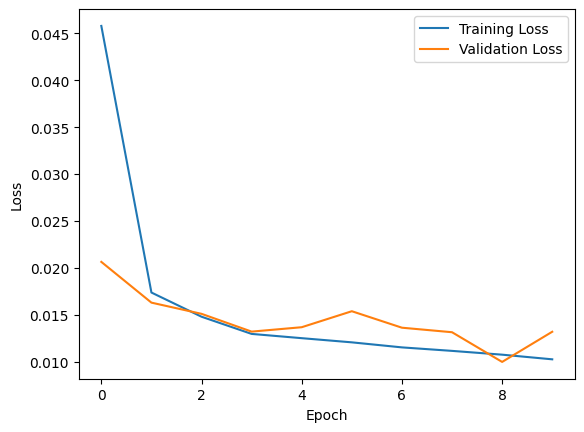

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Threshol
reconstructions = find_anomaly.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:", threshold)


2441/2441 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Threshold: 0.02646779508647249


In [ ]:
encoded_data = find_anomaly.encoder(a_test, )
# Pass the anomalous test data through the encoder to get encoded representations and convert to numpy array.
decoded_data = find_anomaly.decoder(encoded_data).numpy()

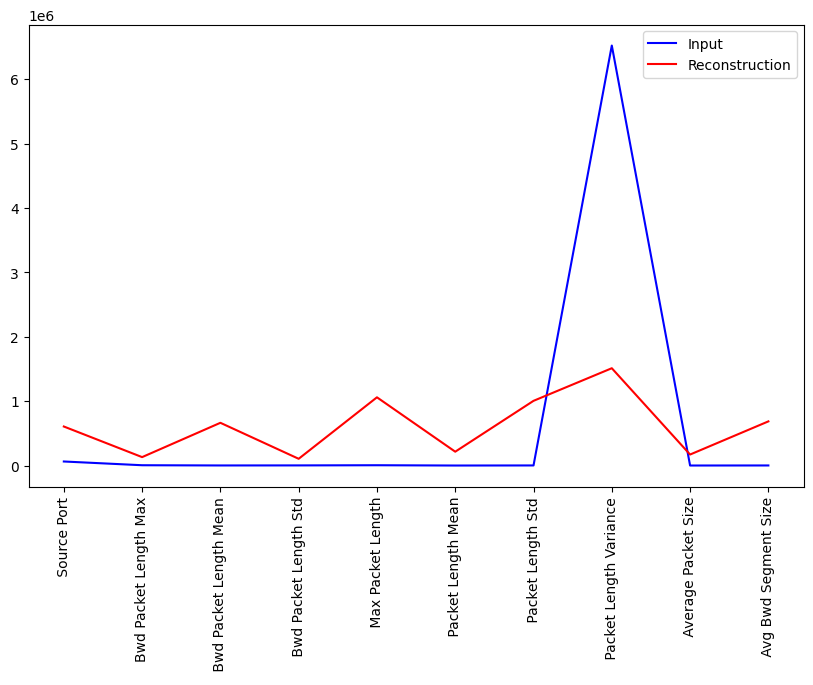

In [ ]:
#ananmoly
plt.figure(figsize=(10, 6))
plt.plot(a_test.iloc[1], 'b')
# Plot the first normal ECG signal in blue.
plt.plot(decoded_data[1], 'r')
# Plot the reconstructed signal in red.
# Fill the area between the original and reconstructed signals to highlight the error.
plt.legend(labels=["Input", "Reconstruction", "Error"])

plt.xticks(rotation = 90)
# Add a legend for the plot.
plt.show()

801/801 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


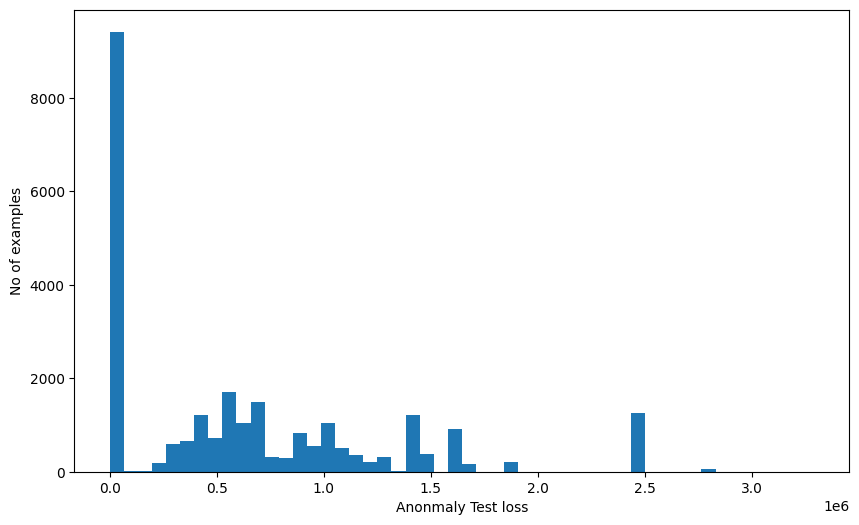

In [ ]:
# calculate the reconstruction error for each instance.

reconstructions = find_anomaly.predict(a_test)
# Use the autoencoder to predict (reconstruct) the normal training data.
train_loss = tf.keras.losses.mae(reconstructions, a_test)
# Calculate the reconstruction loss (MAE) for each sample in the training data.
plt.figure(figsize=(10, 6))
plt.hist(train_loss[None,:], bins=50)
# Plot a histogram of the training loss with 50 bins.
plt.xlabel("Anonmaly Test loss")
# Label the x-axis.
plt.ylabel("No of examples")
# Label the y-axis.
plt.show()
# Display the histogram of training loss.

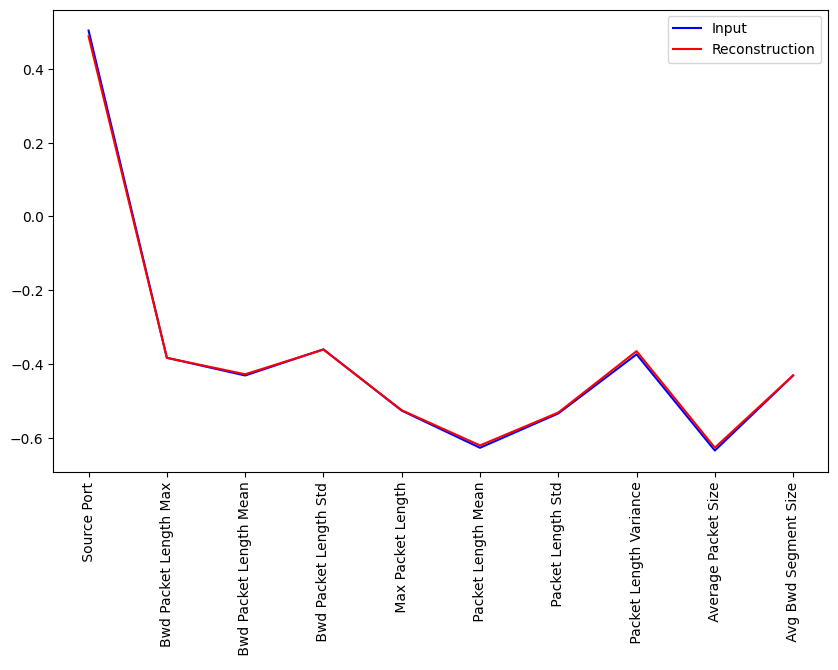

In [ ]:
#normal

encoded_data_norm = find_anomaly.encoder(X_test )
# Pass the anomalous test data through the encoder to get encoded representations and convert to numpy array.
decoded_data_norm = find_anomaly.decoder(encoded_data_norm).numpy()
plt.figure(figsize=(10, 6))
plt.plot(X_test.iloc[1], 'b')
# Plot the first normal ECG signal in blue.
plt.plot(decoded_data_norm[1], 'r')
# Plot the reconstructed signal in red.
# Fill the area between the original and reconstructed signals to highlight the error.
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xticks(rotation = 90)
# Add a legend for the plot.
plt.show()



611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


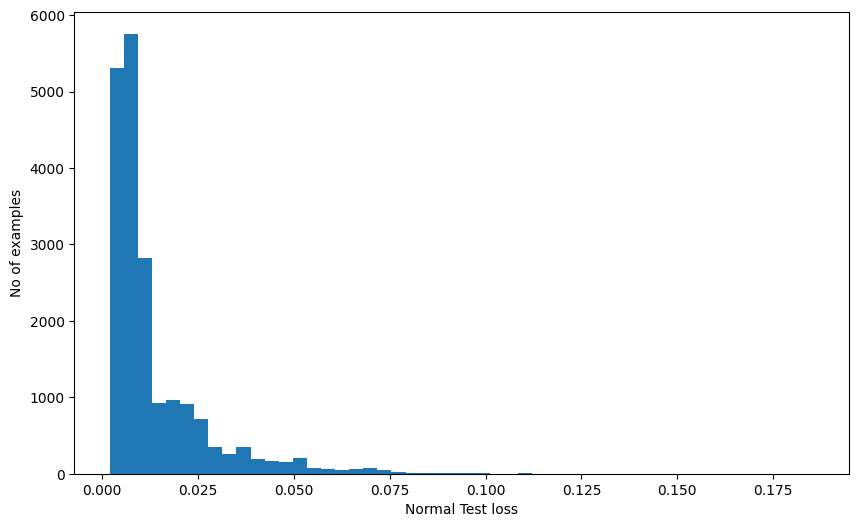

In [ ]:
#calculate the reconstruction error for each instance.

reconstructions = find_anomaly.predict(X_test)
# Use the autoencoder to predict (reconstruct) the normal training data.
train_loss = tf.keras.losses.mae(reconstructions, X_test)
# Calculate the reconstruction loss (MAE) for each sample in the training data.
plt.figure(figsize=(10, 6))
plt.hist(train_loss[None,:], bins=50)
# Plot a histogram of the training loss with 50 bins.
plt.xlabel("Normal Test loss")
# Label the x-axis.
plt.ylabel("No of examples")
# Label the y-axis.
plt.show()
# Display the histogram of training loss.


In [ ]:
from sklearn.metrics import classification_report

# ... (Your existing code) ...

# Thresholding for anomaly detection
reconstructions = find_anomaly.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:", threshold)

# Predictions on the combined test data (normal + anomaly)
combined_test_data = pd.concat([X_test, a_test], ignore_index=True)  # Combine normal and anomaly test data
reconstructions_combined = find_anomaly.predict(combined_test_data)
combined_loss = tf.keras.losses.mae(reconstructions_combined, combined_test_data)
predictions = tf.cast(combined_loss > threshold, tf.int32)  # 1 for anomaly, 0 for normal

# Create combined labels (0 for normal, 1 for anomaly)
combined_labels = np.concatenate([np.zeros(len(X_test)), np.ones(len(a_test))])

# Generate classification report
print(classification_report(combined_labels, predictions))

2441/2441 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Threshold: 0.02646779508647249
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     19527
         1.0       0.91      1.00      0.95     25606

    accuracy                           0.94     45133
   macro avg       0.96      0.94      0.94     45133
weighted avg       0.95      0.94      0.94     45133



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, mean_squared_error, r2_score
x_pred = find_anomaly.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared (R2)
mse = mean_squared_error(X_test, x_pred)
r2 = r2_score(X_test, x_pred)

print(f'Mean Squared Error (MSE): {mse*100:.2f}') #good reconstrction scores
print(f'R-squared (R2): {r2*100:.2f}')

611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error (MSE): 0.04
R-squared (R2): 99.96
